In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random
import importlib

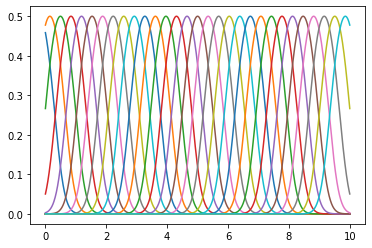

In [10]:
#Architecture parameters and distirbutions of stimuli
N = 30
K = 20
p_x = torch.distributions.uniform.Uniform(0,10)

#Training parameters
#(Note that in this toy model we can generate as many data as we want, since the distribution is relatively simple, so the distinction between N_SAMPLES and BATCH_SIZE is not very neat)
N_EPOCHS = 2000
N_SAMPLES = 1000
lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE)


#Initialization of encoder and decoder 
enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
dec = GaussianDecoder(phi0)

x_fine = torch.linspace(x_min,x_max,1000)[:,None]
plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach());

In [11]:
lossVec = []
mseVec = []
x_k = p_x.sample((K,))[:,None]
params = list(enc.parameters()) + list(dec.parameters()) + list(x_k)
optimizer = torch.optim.Adam(params,0.001)

for epoch in range(N_EPOCHS):
    for x_ in x_data:
        dloss = distortion_gaussian(x_,enc,dec) 
        rloss =  rate_vampBernoulli(x_,enc,x_k)
        loss = dloss + 0.1*rloss
        print(loss)
        lossVec.append(loss.item())
        
        mseVec.append(MSE_montecarlo(x_,enc,dec).item())
        #print(torch.softmax(decoder.qs,dim=1))
        if not torch.isnan(loss):
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if torch.isnan(loss):
            print("AHHHHHHHHHHHHHHHH")
            break;

tensor(-0.0708, grad_fn=<AddBackward0>)
tensor(-0.0519, grad_fn=<AddBackward0>)
tensor(-0.0534, grad_fn=<AddBackward0>)
tensor(-0.0599, grad_fn=<AddBackward0>)
tensor(-0.0591, grad_fn=<AddBackward0>)
tensor(-0.0578, grad_fn=<AddBackward0>)
tensor(-0.0582, grad_fn=<AddBackward0>)
tensor(-0.0551, grad_fn=<AddBackward0>)
tensor(-0.0643, grad_fn=<AddBackward0>)
tensor(-0.0502, grad_fn=<AddBackward0>)
tensor(-0.0777, grad_fn=<AddBackward0>)
tensor(-0.0575, grad_fn=<AddBackward0>)
tensor(-0.0634, grad_fn=<AddBackward0>)
tensor(-0.0548, grad_fn=<AddBackward0>)
tensor(-0.0653, grad_fn=<AddBackward0>)
tensor(-0.0484, grad_fn=<AddBackward0>)
tensor(-0.0680, grad_fn=<AddBackward0>)
tensor(-0.0479, grad_fn=<AddBackward0>)
tensor(-0.0631, grad_fn=<AddBackward0>)
tensor(-0.0525, grad_fn=<AddBackward0>)
tensor(-0.0605, grad_fn=<AddBackward0>)
tensor(-0.0519, grad_fn=<AddBackward0>)
tensor(-0.0683, grad_fn=<AddBackward0>)
tensor(-0.0550, grad_fn=<AddBackward0>)
tensor(-0.0694, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

(0.0, 30.0)

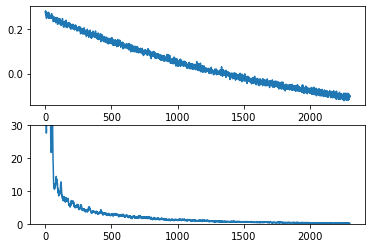

In [12]:
fig, axs = plt.subplots(2);
axs[0].plot(lossVec);
axs[1].plot(mseVec);
axs[1].set_ylim(0,30)

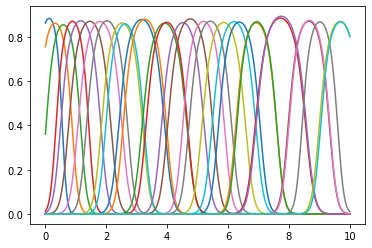

In [14]:

plt.plot(x_fine,torch.sigmoid(enc(x_fine)).detach());
#for x_ in x_k:
#    plt.axvline(x_)

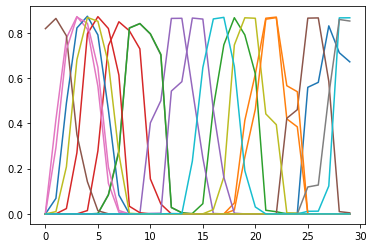

In [15]:
#rate_vampBernoulli(x_sorted,enc,x_k)
l_r_x = enc(x_sorted)[:,:,None]
l_r = enc(x_k).transpose(0,1)[None,:,:]
KLs = (torch.sigmoid(l_r_x)*(F.logsigmoid(l_r_x) - F.logsigmoid(l_r)) + 
torch.sigmoid(-l_r_x)*(F.logsigmoid(-l_r_x) - F.logsigmoid(-l_r))).sum(dim=1)
#plt.plot(KLs[:,1].detach())
plt.plot(torch.sigmoid(l_r[0,:,:]).detach())


In [78]:
l_r.shape

torch.Size([1, 30, 10])

In [74]:
DVec = []
DtVec = []
RVec = []

for sigmai in np.arange(0.01,0.2,0.01):
    enc = BernoulliEncoder(N,x_min-0.2,x_max+0.2)
    enc.log_sigmas = torch.nn.Parameter(torch.log(sigmai*torch.ones(N)[None,:]))
    inv_sigma2 = torch.exp(-2*enc.log_sigmas).transpose(0,1)
    phi0 = torch.cat((enc.cs.transpose(0,1)*inv_sigma2,-0.5*inv_sigma2),dim=1)
    dec = GaussianDecoder(phi0)
    DVec.append(distortion_gaussian(x_sorted,enc,dec,tau=0.1).item())
    DtVec.append(distortion_ideal(x_sorted,enc,tau=0.1).item())
    l_r_x = enc(x_sorted)
    #Dkl between two bernoulli distributions
    x_k = x_sorted[random.sample(range(500),K)]
    R =rate_vampBernoulli(x_sorted,enc,x_k)
    #print(R)
    RVec.append(R.item())
    


tensor([55.8933])


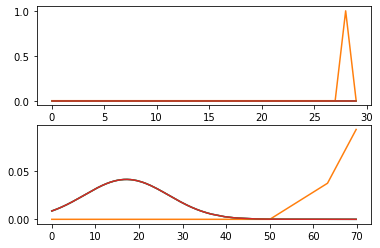

In [12]:
r = enc.sample(x_fine,10)
ix = 800
print(x_fine[ix])
mu_dec,sigma2_dec = dec(r)
with torch.no_grad():
    nsample =[1,3,5,7]
    fig,(ax1,ax2) = plt.subplots(2)
    q_x_r = torch.exp(torch.distributions.normal.Normal(mu_dec[ix,nsample],torch.sqrt(sigma2_dec[ix,nsample])).log_prob(x_sorted))
    ax1.plot(range(N),r[ix,nsample,:].transpose(0,1))
    ax2.plot(x_sorted,q_x_r)
    #plt.show()
    

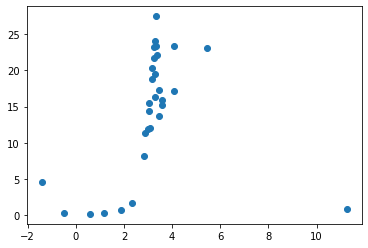

In [58]:
plt.scatter(enc.cs.detach(),torch.exp(enc.log_sigmas).detach())

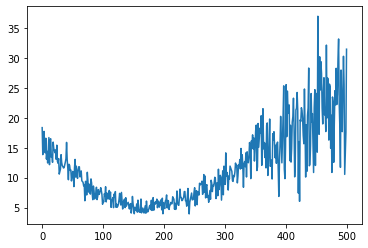

In [19]:
r = enc.sample(x_sorted,10)
x_dec = dec.sample(r,10)
mseVec = ((x_dec - x_sorted[None,:])**2).mean(dim=(0,2))
plt.plot(mseVec.detach())

In [70]:
loss = rate_iidBernoulli(x_sorted,enc,0.1)
x_k = p_x.sample((K,))[:,None]
lossVamp = rate_vampBernoulli(x_sorted,enc,x_k)

In [73]:
lossVamp.item().isnan()

AttributeError: 'float' object has no attribute 'isnan'

In [40]:
torch.distributions.bernoulli.Bernoulli(torch.sigmoid(l_j_x))

ValueError: The parameter probs has invalid values